<a href="https://colab.research.google.com/github/hrtnisri2016/vix-ds-hci/blob/main/Home_Credit_Default_Risk_(Data_Cleaning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

**Import libraries**

In [ ]:
import os
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display, HTML

# Set the dark background for the entire plot
plt.style.use('dark_background')

**Functions**

In [ ]:
# function to create scrollable output within a small window
def create_scrollable_output(content, title):
    html = f'<h3>{title}</h3>'
    html += f'<pre style="height:200px; overflow:auto;">'
    html += content
    html += '</pre>'
    return html

In [ ]:
# To make a plot visualizing the number of missing values
def plot_missing_values(df, filename, y_axis_format=True):
    fig, ax = plt.subplots(figsize=(6, 3))
    isna_sum = df.isna().sum()

    # Sort the missing values in descending order
    isna_sum_sorted = isna_sum[isna_sum > 0].sort_values(ascending=False)  
    isna_sum_sorted.plot(kind='bar', color='gold')
    ax.set_title(f'Missing values in {filename} data', weight='bold')
    
    # Format the y-axis tick labels to display values as "50k", "100k", "150k", etc.
    if y_axis_format == True:
        formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k' if x != 0 else '0')
        ax.yaxis.set_major_formatter(formatter)

    return fig, ax

In [ ]:
def check_missing_AMT_REQ(df_application, df_bureau):
    columns_AMT_REQ = [
        'AMT_REQ_CREDIT_BUREAU_HOUR',
        'AMT_REQ_CREDIT_BUREAU_DAY',
        'AMT_REQ_CREDIT_BUREAU_WEEK',
        'AMT_REQ_CREDIT_BUREAU_MON',
        'AMT_REQ_CREDIT_BUREAU_QRT',
        'AMT_REQ_CREDIT_BUREAU_YEAR']
    missing_AMT_REQ = df_application[df_application[columns_AMT_REQ].isna()]['SK_ID_CURR'].to_list()

    # Filter df_bureau based on matching SK_ID_CURR values
    df_bureau_matched = df_bureau[df_bureau['SK_ID_CURR'].isin(missing_AMT_REQ)]

    if not df_bureau_matched.empty:
        print(df_bureau_matched)
    else:
        print('No matching SK_ID_CURR values were found in the bureau table.\nMissing values have been filled with 0.')
        # Fill missing values with 0 in the selected columns
        df_application[columns_AMT_REQ] = df_application[columns_AMT_REQ].fillna(0)

**Get data**

In [ ]:
folder_path = '/content/drive/MyDrive/home-credit-default-risk'

file_dict = {}  # Dictionary to store file paths

# List all files in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_name = os.path.splitext(file)[0]  # Get the file name without extension
        file_dict[file_name] = file_path

# Print the dictionary
out = ''
for file_name, file_path in file_dict.items():
    out += f'\u2022 {file_name}\n  {file_path}\n'

display(HTML(create_scrollable_output(out, 'File name and its path')))

In [ ]:
# application_train
path_application_train = file_dict['application_train_valid']
df_application_train = pd.read_csv(path_application_train)
print(f'\u2022 application_train\n  shape: {df_application_train.shape}')

# application_test
path_application_test = file_dict['application_test_valid']
df_application_test = pd.read_csv(path_application_test)
print(f'\u2022 application_test\n  shape: {df_application_test.shape}')

# bureau
path_bureau = file_dict['bureau_valid']
df_bureau = pd.read_csv(path_bureau)
print(f'\u2022 bureau\n  shape: {df_bureau.shape}')

# bureau_balance
path_bureau_balance = file_dict['bureau_balance']
df_bureau_balance = pd.read_csv(path_bureau_balance)
print(f'\u2022 bureau_balance\n  shape: {df_bureau_balance.shape}')

# POS_CASH_balance
path_POS_CASH_balance = file_dict['POS_CASH_balance_valid']
df_POS_CASH_balance = pd.read_csv(path_POS_CASH_balance)
print(f'\u2022 POS_CASH_balance\n  shape: {df_POS_CASH_balance.shape}')

# credit_card_balance
path_credit_card_balance = file_dict['credit_card_balance']
df_credit_card_balance = pd.read_csv(path_credit_card_balance)
print(f'\u2022 credit_card_balance\n  shape: {df_credit_card_balance.shape}')

# previous_application
path_previous_application = file_dict['previous_application_valid']
df_previous_application = pd.read_csv(path_previous_application)
print(f'\u2022 previous_application\n  shape: {df_previous_application.shape}')

# installments_payments
path_installments_payments = file_dict['installments_payments']
df_installments_payments = pd.read_csv(path_installments_payments)
print(f'\u2022 installments_payments\n  shape: {df_installments_payments.shape}')

• application_train
  shape: (307510, 75)
• application_test
  shape: (48744, 121)
• bureau
  shape: (1716428, 15)
• bureau_balance
  shape: (27299925, 3)
• POS_CASH_balance
  shape: (10001358, 8)
• credit_card_balance
  shape: (3840312, 23)
• previous_application
  shape: (1670214, 21)
• installments_payments
  shape: (13605401, 8)


# **Prepare the `application_train` data**

In [ ]:
# Print the first few rows
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Check for duplicate rows
df_application_train_without_id = df_application_train.drop(columns=['SK_ID_CURR'])
df_application_train_without_id[df_application_train_without_id.duplicated(keep=False)]

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


There is no duplicate observation in this dataset.

In [ ]:
# Get the column names of df_application_train
features = df_application_train.columns

In [ ]:
# Check TARGET distribution
df_application_train['TARGET'].value_counts() / len(df_application_train) * 100

0    91.927417
1     8.072583
Name: TARGET, dtype: float64

## **Identifying and handling missing values.**

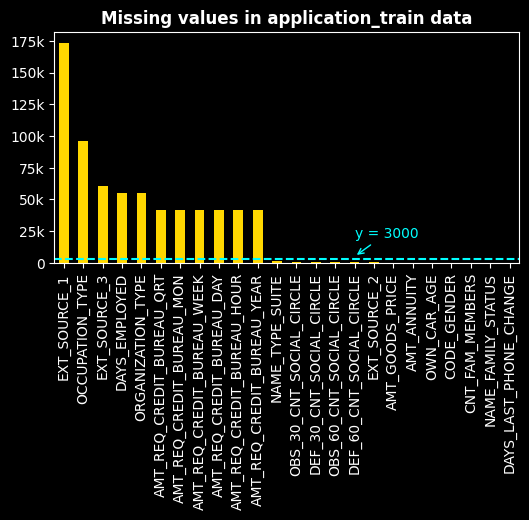

In [ ]:
# Plot the number of missing values
fig, ax = plot_missing_values(df_application_train, 'application_train')

# Add a horizontal dashed line at y=3000
ax.axhline(y=3000, linestyle='--', color='cyan')

# Add an arrow pointer and text annotation
arrow_props = dict(arrowstyle='->', color='cyan')
ax.annotate('y = 3000', xy=(15, 5000), xytext=(15, 20000),
            arrowprops=arrow_props, color='cyan')

# Display the plot
plt.show()

In [ ]:
# Select columns with missing values count between 0 and 3000
isna_sum = df_application_train.isna().sum()
columns_to_dropna = isna_sum[(isna_sum > 0) & (isna_sum < 3000)].index.to_list()

# Drop rows with missing values in selected columns
df_application_train = df_application_train.dropna(subset=columns_to_dropna)

# Print the new shape
print(f'shape: {df_application_train.shape}')

shape: (304524, 75)


These columns have a moderate number of missing values that we can drop without losing a significant amount of data. By dropping these rows, we ensure that our dataset contains only complete observations in the selected columns.

After that, I investigated the columns related to the number of enquiries made to the credit bureau about the client. These columns include `AMT_REQ_CREDIT_BUREAU` for hour, day, week, month, quarter, and year. Initially, I checked if there were any enquiries recorded in the bureau dataset. If there were no enquiries found, I assumed that the missing values in these columns should be filled with 0, indicating that there were no enquiries made to the credit bureau about the client.

In [ ]:
# Check and handle missing values in AMT_REQ columns
check_missing_AMT_REQ(df_application_train, df_bureau)

No matching SK_ID_CURR values were found in the bureau table.
Missing values have been filled with 0.


The next column I examined was `DAYS_EMPLOYED`. Initially, I investigated the income type associated with the missing values in `DAYS_EMPLOYED`.

In [ ]:
df_application_train[
    df_application_train['DAYS_EMPLOYED'].isna()
]['NAME_INCOME_TYPE'].value_counts()

Pensioner     54833
Unemployed       19
Name: NAME_INCOME_TYPE, dtype: int64

It was discovered that the `DAYS_EMPLOYED` column had missing values for pensioners and unemployed individuals. For unemployed individuals, we can set `DAYS_EMPLOYED = 0`. However, for pensioners, further analysis is required since they are also present in the `ORGANIZATION_TYPE` and `OCCUPATION_TYPE` columns associated with the missing values. Therefore, I will handle the pensioner category separately.

In [ ]:
df_application_train[
    df_application_train['ORGANIZATION_TYPE'].isna()
]['NAME_INCOME_TYPE'].value_counts()

Pensioner     54833
Unemployed       19
Name: NAME_INCOME_TYPE, dtype: int64

In [ ]:
df_application_train[
    df_application_train['OCCUPATION_TYPE'].isna()
]['NAME_INCOME_TYPE'].value_counts()

Pensioner               54839
Working                 24686
Commercial associate    12133
State servant            3749
Unemployed                 19
Student                     4
Businessman                 2
Maternity leave             1
Name: NAME_INCOME_TYPE, dtype: int64

Meanwhile, I'll assign the following values for unemployed individuals: 

`DAYS_EMPLOYED = 0`, 

`OCCUPATION_TYPE = 'None'`, and 

`ORGANIZATION_TYPE = 'None'`.

In [ ]:
# Identify unemployed individuals
is_unemployed = df_application_train['NAME_INCOME_TYPE'] == 'Unemployed'

# Set 'DAYS_EMPLOYED' to 0 
df_application_train.loc[is_unemployed, 'DAYS_EMPLOYED'] = 0
# Set 'OCCUPATION_TYPE' to 'None' 
df_application_train.loc[is_unemployed, 'OCCUPATION_TYPE'] = 'None'
# Set 'ORGANIZATION_TYPE' to 'None' 
df_application_train.loc[is_unemployed, 'ORGANIZATION_TYPE'] = 'None'

For the `Pensioner` category, there are only 8 records with non-null values in the `DAYS_EMPLOYED` column, while a significant number of 54833 records have missing values. Moreover, only two rows have a known `OCCUPATION_TYPE` value. Considering this limited and unrepresentative data, it is not advisable to impute the missing values for `Pensioner` based on this information alone. Instead, I will impute the missing values for `DAYS_EMPLOYED` in the `Pensioner` category using the mean value, and the missing `OCCUPATION_TYPE` and `ORGANIZATION_TYPE` values with the mode. Further steps will be taken to address the remaining missing values in the `OCCUPATION_TYPE` column.

In [ ]:
# Filter rows for the 'Pensioner' category with non-null values in 'DAYS_EMPLOYED'
is_pensioner = df_application_train['NAME_INCOME_TYPE'] == 'Pensioner'
is_missing_days_employed = df_application_train['DAYS_EMPLOYED'].isna()
pensioner_records = df_application_train[is_pensioner & ~is_missing_days_employed]

# Display the subset dataframe
pensioner_records[['SK_ID_CURR', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']]

,SK_ID_CURR,DAYS_EMPLOYED,OCCUPATION_TYPE,ORGANIZATION_TYPE
18195,121224,-1346.0,NaN,Business Entity Type 2
108372,225712,-11194.0,NaN,Business Entity Type 3
113693,231855,-12865.0,Medicine staff,Medicine
124164,243990,-1895.0,NaN,Business Entity Type 3
134594,256117,-8140.0,NaN,Military
206029,338811,-3261.0,NaN,Trade: type 7
274862,418551,-1636.0,Sales staff,Self-employed
291643,437867,-1669.0,NaN,School


In [ ]:
# Calculate the mean of DAYS_EMPLOYED
mean_days_employed = df_application_train['DAYS_EMPLOYED'].mean()

# Calculate the mode of OCCUPATION_TYPE and ORGANIZATION_TYPE
mode_occupation_type = df_application_train['OCCUPATION_TYPE'].mode().iloc[0]
mode_organization_type = df_application_train['ORGANIZATION_TYPE'].mode().iloc[0]

# Identify the missing pensioner records
is_missing_occupation_type = df_application_train['OCCUPATION_TYPE'].isna()
missing_pensioner_records_1 = is_pensioner & is_missing_days_employed
missing_pensioner_records_2 = is_pensioner & is_missing_occupation_type

# Fill missing values for pensioner records with mean days employed, mode occupation type, and mode organization type
df_application_train.loc[missing_pensioner_records_1, 'DAYS_EMPLOYED'] = mean_days_employed
df_application_train.loc[missing_pensioner_records_1, 'ORGANIZATION_TYPE'] = mode_organization_type
df_application_train.loc[missing_pensioner_records_2, 'OCCUPATION_TYPE'] = mode_occupation_type

To address the remaining missing values in the `OCCUPATION_TYPE` column, I have made the decision to impute them using the mode of the occupation type associated with each specific `NAME_INCOME_TYPE`. This approach seems more appropriate as the `NAME_INCOME_TYPE` categories vary, ranging from businessmen to state servants to students.

In [ ]:
# Group the DataFrame by 'NAME_INCOME_TYPE' and find the mode of 'OCCUPATION_TYPE' for each group
df_application_train.groupby('NAME_INCOME_TYPE')['OCCUPATION_TYPE'].apply(lambda x: x.mode().iloc[0])

NAME_INCOME_TYPE
Businessman               Managers
Commercial associate      Laborers
Maternity leave         Core staff
Pensioner                 Laborers
State servant           Core staff
Student                   Laborers
Unemployed                    None
Working                   Laborers
Name: OCCUPATION_TYPE, dtype: object

In [ ]:
# Calculate the mode of 'OCCUPATION_TYPE' for each 'NAME_INCOME_TYPE' group
mode_occupation_type = df_application_train.groupby('NAME_INCOME_TYPE')['OCCUPATION_TYPE'].transform(lambda x: x.mode().iloc[0])

# Fill the missing values in 'OCCUPATION_TYPE' with the mode for each income type
df_application_train['OCCUPATION_TYPE'] = df_application_train['OCCUPATION_TYPE'].fillna(mode_occupation_type)

For the remaining two columns that contain missing values, I created two new columns named `EXT_SOURCE_MEAN` and `EXT_SOURCE_MEDIAN`. These new columns are calculated based on the values from the existing columns `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`. 

After calculating the mean and median values, I excluded the original three columns from the table. This was done to remove them from further analysis and focus only on the newly created columns.

In [ ]:
# Calculate the mean of EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
df_application_train['EXT_SOURCE_MEAN'] = df_application_train[['EXT_SOURCE_1', 
                                                'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# Calculate the median of EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
df_application_train['EXT_SOURCE_MEDIAN'] = df_application_train[['EXT_SOURCE_1', 
                                                'EXT_SOURCE_2', 'EXT_SOURCE_3']].median(axis=1)

# Drop the columns EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
df_application_train.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1, inplace=True)

## **Checking if there are any missing values for the last time.**

In [ ]:
isna_counts = df_application_train.isna().sum()
if not isna_counts[isna_counts > 0].any():
    print('All clear')
else:
    print(isna_counts[isna_counts > 0])

All clear


## **Data type conversion**

In [ ]:
# Print column names with float data type
float_columns = df_application_train.columns[df_application_train.dtypes == float]
print("Columns with float data type:", float_columns)

Columns with float data type: Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'EXT_SOURCE_MEAN', 'EXT_SOURCE_MEDIAN'],
      dtype='object')


I performed data type conversion on the following columns:

- `DAYS_EMPLOYED`
- `DAYS_REGISTRATION`
- `OWN_CAR_AGE`
- `CNT_FAM_MEMBERS`
- `OBS_30_CNT_SOCIAL_CIRCLE`
- `DEF_30_CNT_SOCIAL_CIRCLE`
- `OBS_60_CNT_SOCIAL_CIRCLE`
- `DEF_60_CNT_SOCIAL_CIRCLE`
- `DAYS_LAST_PHONE_CHANGE`
- `AMT_REQ_CREDIT_BUREAU_HOUR`
- `AMT_REQ_CREDIT_BUREAU_DAY`
- `AMT_REQ_CREDIT_BUREAU_WEEK`
- `AMT_REQ_CREDIT_BUREAU_MON`
- `AMT_REQ_CREDIT_BUREAU_QRT`
- `AMT_REQ_CREDIT_BUREAU_YEAR`

I converted the float columns to integer data type. These columns represent the number of days, the number of family members, and the number of inquiries.

In [ ]:
# List of columns to be converted from float to int data type
columns_to_convert = [
    'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR']

# Convert the columns from float to int data type
df_application_train[columns_to_convert] = df_application_train[columns_to_convert].astype(int)

# **Prepare the `application_test` data**

In [ ]:
# Drop the 'TARGET' column from the 'features' list
features = features.drop('TARGET')

# Select only the columns in 'features' from the 'df_application_test' DataFrame
df_application_test = df_application_test[features]

# Display the first few rows of the modified DataFrame
df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## **Identifying and handling missing values**

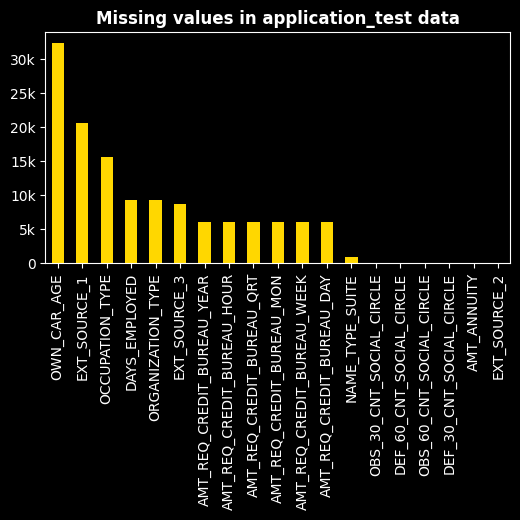

In [ ]:
# Plot the number of missing values
fig, ax = plot_missing_values(df_application_test, 'application_test')
plt.show()

**Handling missing values in**
* `AMT_REQ_CREDIT_BUREAU_HOUR`, 
* `AMT_REQ_CREDIT_BUREAU_DAY`, 
* `AMT_REQ_CREDIT_BUREAU_WEEK`, 
* `AMT_REQ_CREDIT_BUREAU_MON`, 
* `AMT_REQ_CREDIT_BUREAU_QRT`, 
* `AMT_REQ_CREDIT_BUREAU_YEAR`


In [ ]:
# Check and handle missing values in AMT_REQ columns
check_missing_AMT_REQ(df_application_test, df_bureau)

No matching SK_ID_CURR values were found in the bureau table.
Missing values have been filled with 0.


**Handling missing values in `EXT_SOURCE` columns**

In [ ]:
# Calculate the mean of EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
df_application_test['EXT_SOURCE_MEAN'] = df_application_test[
    ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# Calculate the median of EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
df_application_test['EXT_SOURCE_MEDIAN'] = df_application_test[
    ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].median(axis=1)

# Drop the columns EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
df_application_test.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1, inplace=True)

In [ ]:
# check if there is still any missing value
df_application_test[['EXT_SOURCE_MEAN', 'EXT_SOURCE_MEDIAN']].isna().sum()

EXT_SOURCE_MEAN      7
EXT_SOURCE_MEDIAN    7
dtype: int64

In [ ]:
# Calculate the mean value for 'EXT_SOURCE_MEAN' and 'EXT_SOURCE_MEDIAN' in df_application_train
mean_ext_source_mean = df_application_train['EXT_SOURCE_MEAN'].mean()
mean_ext_source_median = df_application_train['EXT_SOURCE_MEDIAN'].mean()

# Fill the missing values in 'EXT_SOURCE_MEAN' and 'EXT_SOURCE_MEDIAN' column with the mean value
df_application_test['EXT_SOURCE_MEAN'] = df_application_test['EXT_SOURCE_MEAN'].fillna(mean_ext_source_mean)
df_application_test['EXT_SOURCE_MEDIAN'] = df_application_test['EXT_SOURCE_MEDIAN'].fillna(mean_ext_source_median)

**Handling missing values in `OWN_CAR_AGE` column**

In [ ]:
# Check the occurrences of missing values in the 'OWN_CAR_AGE' column, filtered by the 'FLAG_OWN_CAR' column
df_application_test[df_application_test['OWN_CAR_AGE'].isna()]['FLAG_OWN_CAR'].value_counts()

N    32311
Y        1
Name: FLAG_OWN_CAR, dtype: int64

Apart from one row, it was observed that the missing values in the `OWN_CAR_AGE` column correspond to cases where `FLAG_OWN_CAR` is set to `N`, indicating that the individuals do not own a car. Therefore, for these specific missing values, the `OWN_CAR_AGE` will be filled with 0.

In the case of the one missing value where the individual actually owns a car, the `OWN_CAR_AGE` column will be filled with the mean value from the `OWN_CAR_AGE` column in the `df_application_train` dataset.

In [ ]:
# Get indices where FLAG_OWN_CAR is 'N' and OWN_CAR_AGE is null
indices = df_application_test[
    (df_application_test['FLAG_OWN_CAR'] == 'N') & df_application_test['OWN_CAR_AGE'].isna()].index

# Fill null values with 0 for the selected indices
df_application_test.loc[indices, 'OWN_CAR_AGE'] = 0

# Fill the last missing value in 'OWN_CAR_AGE' with the mean of 'OWN_CAR_AGE' from df_application_train
has_car = df_application_train[df_application_train['FLAG_OWN_CAR'] == 'Y']
mean_own_car_age = has_car['OWN_CAR_AGE'].mean()
df_application_test['OWN_CAR_AGE'] = df_application_test['OWN_CAR_AGE'].fillna(mean_own_car_age)

**Handling missing values in `AMT_ANNUITY` column**

In [ ]:
# Check the occurrences of missing values in the 'AMT_ANNUITY' column, filtered by the 'NAME_CONTRACT_TYPE' column
df_application_test[df_application_test['AMT_ANNUITY'].isna()]['NAME_CONTRACT_TYPE'].value_counts()

Cash loans    24
Name: NAME_CONTRACT_TYPE, dtype: int64

In [ ]:
# Fill missing values in 'AMT_ANNUITY' with the mean of 'AMT_ANNUITY' from df_application_train
is_cash_loans = df_application_train[df_application_train['NAME_CONTRACT_TYPE'] == 'Cash loans']
mean_amt_annuity = is_cash_loans['AMT_ANNUITY'].mean()
df_application_test['AMT_ANNUITY'] = df_application_test['AMT_ANNUITY'].fillna(mean_amt_annuity)

**Handling missing values in `NAME_TYPE_SUITE` column**

In [ ]:
# Calculate the mode of NAME_TYPE_SUITE from df_application_train
mode_name_type_suite = df_application_train['NAME_TYPE_SUITE'].mode().values[0]

# Fill the missing values in NAME_TYPE_SUITE column with the mode
df_application_test['NAME_TYPE_SUITE'] = df_application_test['NAME_TYPE_SUITE'].fillna(mode_name_type_suite)

**Handling missing values in `OBS_30_CNT_SOCIAL_CIRCLE`, `DEF_30_CNT_SOCIAL_CIRCLE`, `OBS_60_CNT_SOCIAL_CIRCLE`, and `DEF_60_CNT_SOCIAL_CIRCLE` column**

In [ ]:
# Fill missing values in OBS_30_CNT_SOCIAL_CIRCLE column
df_application_test['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(
    df_application_train['OBS_30_CNT_SOCIAL_CIRCLE'].mode().iloc[0], 
    inplace=True)

# Fill missing values in DEF_30_CNT_SOCIAL_CIRCLE column
df_application_test['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(
    df_application_train['DEF_30_CNT_SOCIAL_CIRCLE'].mode().iloc[0], 
    inplace=True)

# Fill missing values in OBS_60_CNT_SOCIAL_CIRCLE column
df_application_test['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(
    df_application_train['OBS_60_CNT_SOCIAL_CIRCLE'].mode().iloc[0], 
    inplace=True)

# Fill missing values in DEF_60_CNT_SOCIAL_CIRCLE column
df_application_test['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(
    df_application_train['DEF_60_CNT_SOCIAL_CIRCLE'].mode().iloc[0], 
    inplace=True)

**Handling missing values in `DAYS_EMPLOYED`, `ORGANIZATION_TYPE`, and `OCCUPATION_TYPE` column**

In [ ]:
df_application_test[df_application_test['DAYS_EMPLOYED'].isna()]['NAME_INCOME_TYPE'].value_counts()

Pensioner     9273
Unemployed       1
Name: NAME_INCOME_TYPE, dtype: int64

In [ ]:
df_application_test[df_application_test['ORGANIZATION_TYPE'].isna()]['NAME_INCOME_TYPE'].value_counts()

Pensioner     9273
Unemployed       1
Name: NAME_INCOME_TYPE, dtype: int64

In [ ]:
df_application_test[df_application_test['OCCUPATION_TYPE'].isna()]['NAME_INCOME_TYPE'].value_counts()

Pensioner               9273
Working                 3818
Commercial associate    1926
State servant            586
Businessman                1
Unemployed                 1
Name: NAME_INCOME_TYPE, dtype: int64

* **Case 1**: `Unemployed` individuals

In [ ]:
# Identify unemployed individuals
is_unemployed = df_application_test['NAME_INCOME_TYPE'] == 'Unemployed'

# Set 'DAYS_EMPLOYED' to 0 
df_application_test.loc[is_unemployed, 'DAYS_EMPLOYED'] = 0
# Set 'OCCUPATION_TYPE' to 'None' 
df_application_test.loc[is_unemployed, 'OCCUPATION_TYPE'] = 'None'
# Set 'ORGANIZATION_TYPE' to 'None' 
df_application_test.loc[is_unemployed, 'ORGANIZATION_TYPE'] = 'None'

* **Case 2**: `Pensioner` individuals

In [ ]:
# Identify the missing pensioner records
is_pensioner = df_application_test['NAME_INCOME_TYPE'] == 'Pensioner'
is_missing_days_employed = df_application_test['DAYS_EMPLOYED'].isna()
is_missing_occupation_type = df_application_test['OCCUPATION_TYPE'].isna()

missing_pensioner_records_1 = is_pensioner & is_missing_days_employed
missing_pensioner_records_2 = is_pensioner & is_missing_occupation_type

# Fill missing values for pensioner records with mean days employed, mode occupation type, 
# and mode organization type from df_application_train data
df_application_test.loc[missing_pensioner_records_1, 'DAYS_EMPLOYED'] = mean_days_employed
df_application_test.loc[missing_pensioner_records_1, 'ORGANIZATION_TYPE'] = mode_organization_type
df_application_test.loc[missing_pensioner_records_2, 'OCCUPATION_TYPE'] = mode_occupation_type

* **Case 3**: the others

In [ ]:
# Create a DataFrame with 'NAME_INCOME_TYPE' and corresponding mode values
mode_df = df_application_train.groupby('NAME_INCOME_TYPE')['OCCUPATION_TYPE']\
                              .apply(lambda x: x.mode().iloc[0])\
                              .to_frame(name='OCCUPATION_TYPE_MODE')\
                              .reset_index()

In [ ]:
# Merge mode_df with df_application_test based on 'NAME_INCOME_TYPE'
df_application_test = df_application_test.merge(mode_df, on='NAME_INCOME_TYPE', how='left')

# Fill missing values in 'OCCUPATION_TYPE' of df_application_test with mode values
df_application_test['OCCUPATION_TYPE'].fillna(df_application_test['OCCUPATION_TYPE_MODE'], inplace=True)

# Drop the 'OCCUPATION_TYPE_MODE' column
df_application_test.drop('OCCUPATION_TYPE_MODE', axis=1, inplace=True)

## **Check if there are any missing values for the last time**

In [ ]:
isna_counts = df_application_test.isna().sum()
if not isna_counts[isna_counts > 0].any():
    print('All clear')
else:
    print(isna_counts[isna_counts > 0])

All clear


## **Data type conversion**

In [ ]:
# Print column names with float data type
float_columns = df_application_test.columns[df_application_test.dtypes == float]
print("Columns with float data type:", float_columns)

Columns with float data type: Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'EXT_SOURCE_MEAN', 'EXT_SOURCE_MEDIAN'],
      dtype='object')


In [ ]:
# List of columns to be converted from float to int data type
columns_to_convert = [
    'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR']

# Convert the columns from float to int data type
df_application_test[columns_to_convert] = df_application_test[columns_to_convert].astype(int)

# **Preparing `bureau` data**

In [ ]:
# Print the first few rows
df_bureau = df_bureau.sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
248484,100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,0,112500.0,0.0,0.0,0.0,Consumer credit,-155
248485,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,0,279720.0,0.0,0.0,0.0,Consumer credit,-155
248486,100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,0,91620.0,0.0,0.0,0.0,Consumer credit,-155
248487,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,0,85500.0,0.0,0.0,0.0,Consumer credit,-155
248488,100001,5896634,Active,currency 1,-559,0,902.0,NaN,0,337680.0,113166.0,0.0,0.0,Consumer credit,-6


## **Remove duplicate observations**

In [ ]:
columns_to_exclude = ['SK_ID_BUREAU']  # Columns to exclude from duplication check
columns_to_check = df_bureau.columns.difference(columns_to_exclude)  # Columns to include in duplication check

# Check for duplicates only in the specified columns
duplicates = df_bureau.duplicated(subset=columns_to_check)

# Access the rows that are not duplicates in the specified columns
print('Before:', df_bureau.shape)
df_bureau = df_bureau[~duplicates]
print('After:', df_bureau.shape)

Before: (1716428, 15)
After: (1713975, 15)


**Get the summary statistics**

In [ ]:
df_bureau.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1713975.0,278212.0,102940.0,100001.0,188862.0,278053.0,367422.0,456255.0
SK_ID_BUREAU,1713975.0,5924367.6,532268.0,5000000.0,5463867.5,5926221.0,6385589.5,6843457.0
DAYS_CREDIT,1713975.0,-1142.6,795.4,-2922.0,-1667.0,-988.0,-474.0,0.0
CREDIT_DAY_OVERDUE,1713975.0,0.8,36.6,0.0,0.0,0.0,0.0,2792.0
DAYS_CREDIT_ENDDATE,1608488.0,509.5,4996.1,-42060.0,-1139.0,-332.0,470.0,31199.0
DAYS_ENDDATE_FACT,1082142.0,-1017.6,714.0,-42023.0,-1489.0,-897.0,-426.0,0.0
CNT_CREDIT_PROLONG,1713975.0,0.0,0.1,0.0,0.0,0.0,0.0,9.0
AMT_CREDIT_SUM,1713962.0,355205.9,1145634.5,0.0,51511.5,125779.5,315000.0,585000000.0
AMT_CREDIT_SUM_DEBT,1456478.0,137227.0,677597.4,-4705600.3,0.0,0.0,40428.0,170100000.0
AMT_CREDIT_SUM_LIMIT,1122813.0,6226.2,45025.4,-586406.1,0.0,0.0,0.0,4705600.3


I will drop the columns `CREDIT_DAYS_OVERDUE`, `CNT_CREDIT_PROLONG`, `AMT_CREDIT_SUM_LIMIT`, and `AMT_CREDIT_SUM_OVERDUE` where three-quarters of the data in these columns are filled with zeros.

In [ ]:
df_bureau.drop(
    columns=['CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE'],
    inplace=True)

## **Handling missing values**

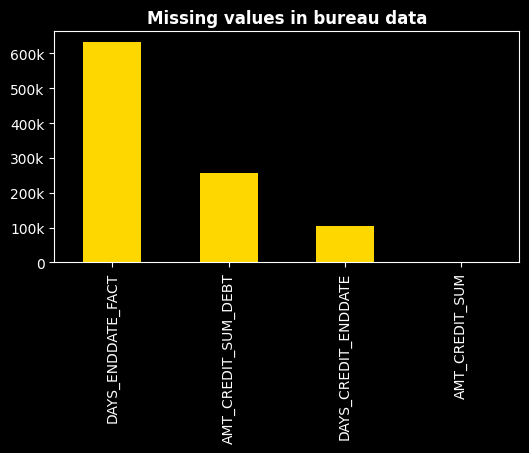

In [ ]:
# Plot the number of missing values
fig, ax = plot_missing_values(df_bureau, 'bureau')
plt.show()

I haven't yet determined the appropriate method for imputing missing values in those columns, so for now, I have made the decision to drop all rows with missing values. This allows me to proceed with the analysis while temporarily disregarding the incomplete data.

In [ ]:
# Drop missing values
df_bureau.dropna(inplace=True)

## **Check if there are any missing values for the last time**

In [ ]:
isna_counts = df_bureau.isna().sum()
if not isna_counts[isna_counts > 0].any():
    print('All clear')
else:
    print(isna_counts[isna_counts > 0])

All clear


## **Data type conversion**

In [ ]:
# List of columns to be converted from float to int data type
columns_to_convert = ['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT']

# Convert the columns from float to int data type
df_bureau[columns_to_convert] = df_bureau[columns_to_convert].astype(int)

# **Preparing `bureau_balance` data**

In [ ]:
# Print the first few rows
df_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
df_bureau_balance.isna().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

# **Preparing `previous_application` data**

In [ ]:
# Print the first few rows
df_previous_application = df_previous_application.sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_PORTFOLIO,CHANNEL_TYPE,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
201668,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,24835.5,FRIDAY,13,Y,...,Approved,-1740,Cash through the bank,XAP,Refreshed,POS,Country-wide,8.0,high,POS mobile with interest
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,179055.0,SATURDAY,9,Y,...,Approved,-606,NaN,XAP,New,POS,Stone,24.0,low_normal,POS other with interest
575941,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,900000.0,FRIDAY,12,Y,...,Approved,-746,NaN,XAP,Repeater,Cash,Credit and cash offices,12.0,low_normal,Cash X-Sell: low
1223745,2396755,100003,Consumer loans,6737.310,68809.5,68053.5,68809.5,SATURDAY,15,Y,...,Approved,-2341,Cash through the bank,XAP,Refreshed,POS,Country-wide,12.0,middle,POS household with interest
1021650,2636178,100003,Consumer loans,64567.665,337500.0,348637.5,337500.0,SUNDAY,17,Y,...,Approved,-828,Cash through the bank,XAP,Refreshed,POS,Stone,6.0,middle,POS industry with interest


## **Remove duplicate observations**

In [ ]:
columns_to_exclude = ['SK_ID_PREV']  # Columns to exclude from duplication check
columns_to_check = df_previous_application.columns.difference(columns_to_exclude)  # Columns to include in duplication check

# Check for duplicates only in the specified columns
duplicates = df_previous_application.duplicated(subset=columns_to_check)

# Access the rows that are not duplicates in the specified columns
print('Before:', df_previous_application.shape)
df_previous_application = df_previous_application[~duplicates]
print('After:', df_previous_application.shape)

Before: (1670214, 21)
After: (1612082, 21)


## **Handling missing values**

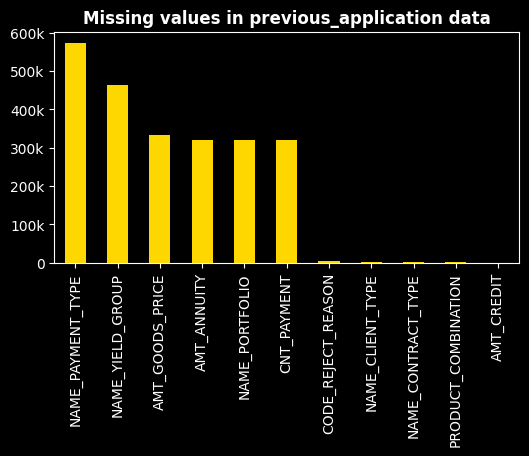

In [ ]:
# Plot the number of missing values
fig, ax = plot_missing_values(df_previous_application, 'previous_application')
plt.show()

> **Handling missing values in `NAME_PAYMENT_TYPE` columns**

In [ ]:
# Extract rows with missing values in 'NAME_PAYMENT_TYPE'
missing_payment_type = df_previous_application[df_previous_application['NAME_PAYMENT_TYPE'].isna()]

In [ ]:
# Count the occurrences of each 'NAME_CONTRACT_STATUS' category in the extracted rows
missing_payment_type['NAME_CONTRACT_STATUS'].value_counts()

Canceled        264690
Approved        211240
Refused          97617
Unused offer       509
Name: NAME_CONTRACT_STATUS, dtype: int64

In [ ]:
# Count the occurrences of each 'NAME_CONTRACT_STATUS' category in the extracted rows
missing_payment_type['NAME_CLIENT_TYPE'].value_counts()

Repeater     481687
New           50229
Refreshed     41015
Name: NAME_CLIENT_TYPE, dtype: int64

The missing values in the `NAME_PAYMENT_TYPE` column are present in both approved and non-approved applications. Therefore, it cannot be assumed that the missing values are only related to applications that were not processed further. Additionally, a large portion of these applications belong to repeater clients, indicating that they are not completely new clients. To handle these missing values, I will impute them using the mode of the `NAME_PAYMENT_TYPE` column.

In [ ]:
# Calculate the mode of the NAME_PAYMENT_TYPE column
mode_payment_type = df_previous_application['NAME_PAYMENT_TYPE'].mode().values[0]
print(mode_payment_type)

# Fill the missing values with the mode
df_previous_application['NAME_PAYMENT_TYPE'].fillna(mode_payment_type, inplace=True)

Cash through the bank


> **Handling missing values in `NAME_YIELD_GROUP` columns**

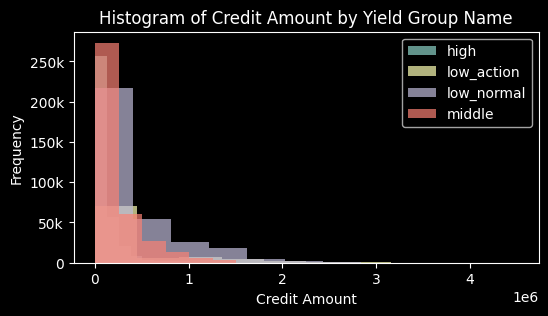

In [ ]:
# Group data by "NAME_YIELD_GROUP"
groups = df_previous_application.groupby('NAME_YIELD_GROUP')

# Plot the histogram
fig, ax = plt.subplots(figsize=(6, 3))
for i, (name, group) in enumerate(groups):
    ax.hist(group['AMT_CREDIT'], bins=10, alpha=0.7, label=name)

# Set labels and title
ax.set_xlabel('Credit Amount')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Credit Amount by Yield Group Name')

# Format y-axis ticks as thousands
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k' if x != 0 else '0')
ax.yaxis.set_major_formatter(formatter)

# Add a legend
ax.legend()

# Show the plot
plt.show()


I expected the yield group to be based on the credit amount, but apparently it is not. Therefore, I will impute the missing values in this column with the mode of the column.

In [ ]:
# Calculate the mode of the NAME_YIELD_GROUP column
mode_yield_group = df_previous_application['NAME_YIELD_GROUP'].mode().values[0]
print(mode_yield_group)

# Fill the missing values with the mode
df_previous_application['NAME_YIELD_GROUP'].fillna(mode_yield_group, inplace=True)

middle


> **Handling missing values in `AMT_CREDIT` columns**

In [ ]:
# View the row with missing AMT_CREDIT
df_previous_application[df_previous_application['AMT_CREDIT'].isna()]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_PORTFOLIO,CHANNEL_TYPE,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
1127152,2204450,438387,Revolving loans,0.0,0.0,NaN,NaN,FRIDAY,10,Y,...,Approved,-608,Cash through the bank,XAP,Repeater,Cards,Country-wide,0.0,middle,Card Street


In [ ]:
# Filter the dataframe for 'Revolving loans' and applied credit amount of 0
revo_loans_zero_amt = df_previous_application[
    (df_previous_application['NAME_CONTRACT_TYPE'] == 'Revolving loans') &
    (df_previous_application['AMT_APPLICATION'] == 0)
].drop(columns=['SK_ID_PREV', 'SK_ID_CURR'])

# Generate descriptive statistics for the filtered dataframe
summary_stats = revo_loans_zero_amt.describe().T.round(1)
summary_stats.loc['AMT_CREDIT']

count      98481.0
mean      149372.8
std       202388.8
min            0.0
25%            0.0
50%        67500.0
75%       225000.0
max      1350000.0
Name: AMT_CREDIT, dtype: float64

There is a possibility that the credit amount given to the client exceeds the applied credit amount. However, considering that 25% of the data has 0 as its value, I will fill the missing values in the `AMT_CREDIT` column with 0. This aligns with the corresponding `AMT_APPLICATION` value.

In [ ]:
# Fill the missing values with 0
df_previous_application['AMT_CREDIT'].fillna(0, inplace=True)

> **Handling missing values in `AMT_GOODS_PRICE` columns**

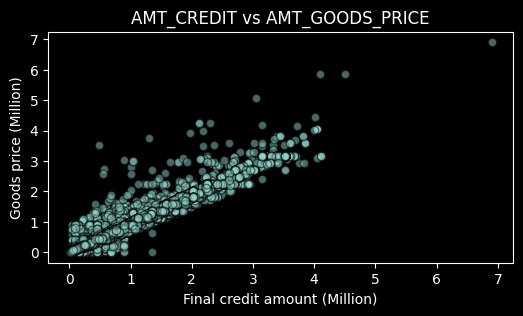

In [ ]:
# Divide the values by one million
amt_credit = df_previous_application['AMT_CREDIT'] / 1000000
amt_goods_price = df_previous_application['AMT_GOODS_PRICE'] / 1000000

# Create the scatter plot with circle boundaries
fig, ax = plt.subplots(figsize=(6, 3))
plt.scatter(amt_credit, amt_goods_price, 
            alpha=0.5, edgecolors='black')

# Set labels and title
plt.xlabel('Final credit amount (Million)')
plt.ylabel('Goods price (Million)')
plt.title('AMT_CREDIT vs AMT_GOODS_PRICE')

# Show the plot
plt.show()

In [ ]:
df_previous_application[['AMT_CREDIT', 'AMT_GOODS_PRICE']].corr()

,AMT_CREDIT,AMT_GOODS_PRICE
AMT_CREDIT,1.000000,0.993076
AMT_GOODS_PRICE,0.993076,1.000000


Based on the plot and the correlation value, there is indeed a strong positive correlation between the `AMT_CREDIT` and `AMT_GOODS_PRICE` columns. However, having two highly correlated features can introduce multicollinearity, which can be problematic in certain statistical models.

To address this problem, I will remove the `AMT_GOODS_PRICE` column instead of filling in its missing values.

In [ ]:
df_previous_application.drop('AMT_GOODS_PRICE', axis=1, inplace=True)

> **Handling missing values in `NAME_CONTRACT_TYPE` columns**

In [ ]:
# Filter rows where 'NAME_CONTRACT_TYPE' is missing
missing_contract_type = df_previous_application[df_previous_application['NAME_CONTRACT_TYPE'].isna()]

In [ ]:
# Calculate the number of rows in missing_contract_type 
# where all specified columns have missing values

columns_of_interest = ['NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 
    'NAME_PORTFOLIO', 'CNT_PAYMENT', 'PRODUCT_COMBINATION']
all_missing_values = missing_contract_type[columns_of_interest].isna().all(axis=1)
total_rows_with_all_missing_values = all_missing_values.sum()
print('Total rows in missing_contract_type:', len(missing_contract_type))
print('Total rows with all specified columns missing:', total_rows_with_all_missing_values)

Total rows in missing_contract_type: 334
Total rows with all specified columns missing: 334


In [ ]:
# Calculate descriptive statistics for 'AMT_APPLICATION' and 'AMT_CREDIT'
missing_contract_type[['AMT_APPLICATION', 'AMT_CREDIT']].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_APPLICATION,334.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AMT_CREDIT,334.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Get the value counts of 'NAME_CONTRACT_STATUS' in the filtered rows
missing_contract_type['NAME_CONTRACT_STATUS'].value_counts()

Canceled    303
Refused      31
Name: NAME_CONTRACT_STATUS, dtype: int64

Considering that the rows with missing values in the `NAME_CONTRACT_TYPE` column also have missing information in other columns such as `AMT_ANNUITY`, `NAME_PORTFOLIO`, `CNT_PAYMENT`, and `PRODUCT_COMBINATION`, it is reasonable to remove these rows as they do not provide useful information. Additionally, these rows only have a value of 0 in both the `AMT_APPLICATION` and `AMT_CREDIT` columns, and the corresponding contracts are either canceled or refused. 

In [ ]:
# Drop the rows corresponding to the indices in missing_contract_type 
df_previous_application.drop(missing_contract_type.index, inplace=True)

> **Handling the other missing values**

The remaining observations with missing values will be deleted.

In [ ]:
df_previous_application.dropna(inplace=True)

## **Check if there are any missing values for the last time**

In [ ]:
isna_counts = df_previous_application.isna().sum()
if not isna_counts[isna_counts > 0].any():
    print('All clear')
else:
    print(isna_counts[isna_counts > 0])

All clear


## **Data type conversion**

In [ ]:
# Convert CNT_PAYMENT column from float to int data type
df_previous_application['CNT_PAYMENT'] = df_previous_application['CNT_PAYMENT'].astype(int)
df_previous_application.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288105 entries, 201668 to 1411592
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1288105 non-null  int64  
 1   SK_ID_CURR                   1288105 non-null  int64  
 2   NAME_CONTRACT_TYPE           1288105 non-null  object 
 3   AMT_ANNUITY                  1288105 non-null  float64
 4   AMT_APPLICATION              1288105 non-null  float64
 5   AMT_CREDIT                   1288105 non-null  float64
 6   WEEKDAY_APPR_PROCESS_START   1288105 non-null  object 
 7   HOUR_APPR_PROCESS_START      1288105 non-null  int64  
 8   FLAG_LAST_APPL_PER_CONTRACT  1288105 non-null  object 
 9   NFLAG_LAST_APPL_IN_DAY       1288105 non-null  int64  
 10  NAME_CONTRACT_STATUS         1288105 non-null  object 
 11  DAYS_DECISION                1288105 non-null  int64  
 12  NAME_PAYMENT_TYPE            1288105 

# **Preparing `POS_CASH_balance` data**

In [ ]:
# Print the first few rows
df_POS_CASH_balance = df_POS_CASH_balance.sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
df_POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2197888,1369693,100001,-53,4.0,0.0,Completed,0,0
4704415,1369693,100001,-54,4.0,1.0,Active,0,0
7167007,1369693,100001,-57,4.0,4.0,Active,0,0
7823681,1369693,100001,-55,4.0,2.0,Active,0,0
8789081,1369693,100001,-56,4.0,3.0,Active,0,0


## **Remove duplicate observations**

In [ ]:
columns_to_exclude = ['SK_ID_PREV']  # Columns to exclude from duplication check
columns_to_check = df_POS_CASH_balance.columns.difference(columns_to_exclude)  # Columns to include in duplication check

# Check for duplicates only in the specified columns
duplicates = df_POS_CASH_balance.duplicated(subset=columns_to_check)

# Access the rows that are not duplicates in the specified columns
print('Before:', df_POS_CASH_balance.shape)
df_POS_CASH_balance = df_POS_CASH_balance[~duplicates]
print('After:', df_POS_CASH_balance.shape)

Before: (10001358, 8)
After: (9972339, 8)


## **Handling missing values**

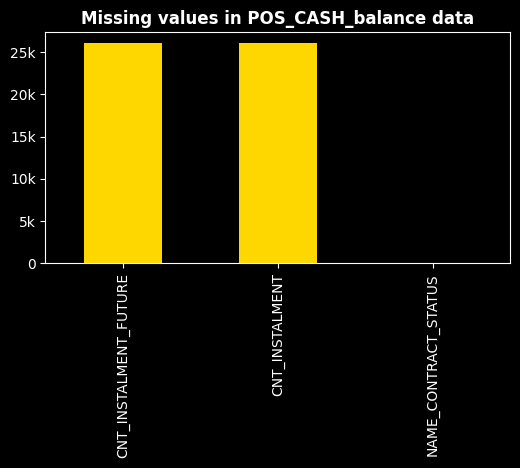

In [ ]:
# Plot the number of missing values
fig, ax = plot_missing_values(df_POS_CASH_balance, 'POS_CASH_balance')
plt.show()

Initially, my intention was to drop only the rows that did not represent the freshest monthly snapshot, as indicated by `MONTH_BALANCE = -1`. However, upon further analysis, I discovered that there are still 462 rows remaining with missing values in both the `CNT_INSTALMENT` and `CNT_INSTALMENT_FUTURE` columns. Consequently, I made the decision to drop all rows with missing values.

In [ ]:
# Drop all missing values
df_POS_CASH_balance.dropna(inplace=True)

## **Check if there are any missing values for the last time**

In [ ]:
isna_counts = df_POS_CASH_balance.isna().sum()
if not isna_counts[isna_counts > 0].any():
    print('All clear')
else:
    print(isna_counts[isna_counts > 0])

All clear


## **Data type conversion**

In [ ]:
df_POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9946161 entries, 2197888 to 8606094
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 682.9+ MB


In [ ]:
# List of columns to be converted from float to int data type
columns_to_convert = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']

# Convert the columns from float to int data type
df_POS_CASH_balance[columns_to_convert] = df_POS_CASH_balance[columns_to_convert].astype(int)

# **Preparing `credit_card_balance` data**

In [ ]:
# Print the first few rows
df_credit_card_balance = df_credit_card_balance.sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
520387,1489396,100006,-2,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
584804,1489396,100006,-1,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
655566,1489396,100006,-5,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1347528,1489396,100006,-3,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1399895,1489396,100006,-4,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0


## **Remove duplicate observations**

In [ ]:
columns_to_exclude = ['SK_ID_PREV']  # Columns to exclude from duplication check
columns_to_check = df_credit_card_balance.columns.difference(columns_to_exclude)  # Columns to include in duplication check

# Check for duplicates only in the specified columns
duplicates = df_credit_card_balance.duplicated(subset=columns_to_check)

# Access the rows that are not duplicates in the specified columns
print('Before:', df_credit_card_balance.shape)
df_credit_card_balance = df_credit_card_balance[~duplicates]
print('After:', df_credit_card_balance.shape)

Before: (3840312, 23)
After: (3840293, 23)


## **Handling missing values**

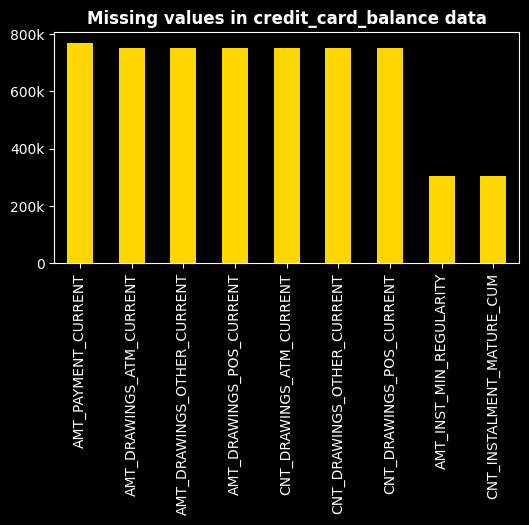

In [ ]:
# Plot the number of missing values
fig, ax = plot_missing_values(df_credit_card_balance, 'credit_card_balance')
plt.show()

In [ ]:
columns_with_nan = ['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
    'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 
    'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
    'CNT_INSTALMENT_MATURE_CUM']

In [ ]:
df_credit_card_balance[columns_with_nan].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
AMT_DRAWINGS_ATM_CURRENT,3090482.0,5961.4,28225.7,-6827.3,0.0,0.0,0.0,2115000.0
AMT_DRAWINGS_OTHER_CURRENT,3090482.0,288.2,8202.0,0.0,0.0,0.0,0.0,1529847.0
AMT_DRAWINGS_POS_CURRENT,3090482.0,2968.8,20796.9,0.0,0.0,0.0,0.0,2239274.2
AMT_INST_MIN_REGULARITY,3535057.0,3540.2,5600.2,0.0,0.0,0.0,6634.2,202882.0
AMT_PAYMENT_CURRENT,3072310.0,10280.6,36078.2,0.0,152.4,2702.7,9000.0,4289207.4
CNT_DRAWINGS_ATM_CURRENT,3090482.0,0.3,1.1,0.0,0.0,0.0,0.0,51.0
CNT_DRAWINGS_OTHER_CURRENT,3090482.0,0.0,0.1,0.0,0.0,0.0,0.0,12.0
CNT_DRAWINGS_POS_CURRENT,3090482.0,0.6,3.2,0.0,0.0,0.0,0.0,165.0
CNT_INSTALMENT_MATURE_CUM,3535057.0,20.8,20.1,0.0,4.0,15.0,32.0,120.0


Since most of the columns have a 75% value of 0, and for the remaining columns, I assume there were no transactions (such as no ATM drawings, no payments made, and no paid installments), I will fill the NaN values with 0 for all these missing values.

In [ ]:
# Fill NaN values with 0 in specified columns
df_credit_card_balance[columns_with_nan] = df_credit_card_balance[columns_with_nan].fillna(0)

## **Check if there are any missing values for the last time**

In [ ]:
isna_counts = df_credit_card_balance.isna().sum()
if not isna_counts[isna_counts > 0].any():
    print('All clear')
else:
    print(isna_counts[isna_counts > 0])

All clear


## **Data type conversion**

In [ ]:
# List of columns to be converted from float to int data type
columns_to_convert = ['CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 
    'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM']

# Convert the columns from float to int data type
df_credit_card_balance[columns_to_convert] = df_credit_card_balance[columns_to_convert].astype(int)

# **Preparing `installments_payments` data**

In [ ]:
# Print the first few rows
df_installments_payments = df_installments_payments.sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1478621,1369693,100001,1.0,1,-1709.0,-1715.0,3951.00,3951.00
2568722,1369693,100001,1.0,2,-1679.0,-1715.0,3951.00,3951.00
2624024,1369693,100001,2.0,4,-1619.0,-1628.0,17397.90,17397.90
3458712,1369693,100001,1.0,3,-1649.0,-1660.0,3951.00,3951.00
1761012,1851984,100001,1.0,2,-2916.0,-2916.0,3982.05,3982.05


## **Remove duplicate observations**

In [ ]:
columns_to_exclude = ['SK_ID_PREV']  # Columns to exclude from duplication check
columns_to_check = df_installments_payments.columns.difference(columns_to_exclude)  # Columns to include in duplication check

# Check for duplicates only in the specified columns
duplicates = df_installments_payments.duplicated(subset=columns_to_check)

# Access the rows that are not duplicates in the specified columns
print('Before:', df_installments_payments.shape)
df_installments_payments = df_installments_payments[~duplicates]
print('After:', df_installments_payments.shape)

Before: (13605401, 8)
After: (13604596, 8)


## **Handling missing values**

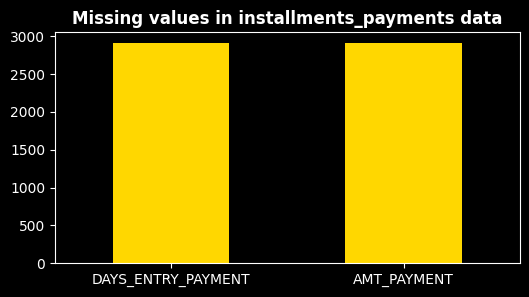

In [ ]:
# Plot the number of missing values
fig, ax = plot_missing_values(df_installments_payments, 'installments_payments', y_axis_format=False)
plt.xticks(rotation=0)
plt.show()

In [ ]:
df_installments_payments[df_installments_payments['DAYS_ENTRY_PAYMENT'].isna()]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3784858,1871097,100224,0.0,59,-1555.0,NaN,67.500,NaN
3789267,1871097,100224,0.0,58,-1586.0,NaN,67.500,NaN
3794762,1871097,100224,0.0,60,-1494.0,NaN,67.500,NaN
3764266,2341414,100260,0.0,31,-1717.0,NaN,67.500,NaN
3794786,2341414,100260,0.0,32,-1686.0,NaN,67.500,NaN
...,...,...,...,...,...,...,...,...
13605376,1421163,453693,0.0,60,-1387.0,NaN,67.500,NaN
13605380,1421163,453693,0.0,59,-1417.0,NaN,67.500,NaN
13588380,2568119,453810,0.0,2,-166.0,NaN,225.000,NaN
13594261,2184228,454195,0.0,20,-2480.0,NaN,0.315,NaN


I assume that missing data in the `DAYS_ENTRY_PAYMENT` and `AMT_PAYMENT` columns indicates people who have not yet made their installment payments. Therefore, I will fill the null values with 0.

In [ ]:
# Fill missing values in 'DAYS_ENTRY_PAYMENT' and 'AMT_PAYMENT' columns with 0
df_installments_payments['DAYS_ENTRY_PAYMENT'].fillna(0, inplace=True)
df_installments_payments['AMT_PAYMENT'].fillna(0, inplace=True)

## **Check if there are any missing values for the last time**

In [ ]:
isna_counts = df_installments_payments.isna().sum()
if not isna_counts[isna_counts > 0].any():
    print('All clear')
else:
    print(isna_counts[isna_counts > 0])

All clear


## **Data type conversion**

In [ ]:
df_installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13604596 entries, 1478621 to 12567314
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 934.2 MB


In [ ]:
# List of columns to be converted from float to int data type
columns_to_convert = ['NUM_INSTALMENT_VERSION', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT']

# Convert the columns from float to int data type
df_installments_payments[columns_to_convert] = df_installments_payments[columns_to_convert].astype(int)
df_installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13604596 entries, 1478621 to 12567314
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  int64  
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         int64  
 5   DAYS_ENTRY_PAYMENT      int64  
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(2), int64(6)
memory usage: 934.2 MB


# Save the newly validated dataset.

In [ ]:
# Define the main path where the files will be saved
main_path = '/content/drive/MyDrive/home-credit-default-risk'

# Save every DataFrame to a CSV file without index
df_application_train.to_csv(
    f'{main_path}/application_train_clean.csv', index=False)
df_application_test.to_csv(
    f'{main_path}/application_test_clean.csv', index=False)
df_bureau.to_csv(
    f'{main_path}/bureau_clean.csv', index=False)
df_bureau_balance.to_csv(
    f'{main_path}/bureau_balance_clean.csv', index=False)
df_previous_application.to_csv(
    f'{main_path}/previous_application_clean.csv', index=False)
df_POS_CASH_balance.to_csv(
    f'{main_path}/POS_CASH_balance_clean.csv', index=False)
df_credit_card_balance.to_csv(
    f'{main_path}/credit_card_balance_clean.csv', index=False)
df_installments_payments.to_csv(
    f'{main_path}/installments_payments_clean.csv', index=False)